# 0 - Information

# 1 - Packages

In [116]:
%matplotlib inline

# Graphic Packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set()

# Dataset packages
import pandas as pd

# Mathematics packages
import numpy as np

# Time package
import pendulum
import datetime as dt

# 2 - Read Data

In this section, we read the data

## 2.1 - Files

In [117]:
# Path of the data
data_case_storage = "stored_data_case.h5"
parkmeter_coords_path = 'parkmeter_coords.h5'

## 2.2 - Reading of the data

In [118]:
def list_HDF_file(file_name):
    with pd.HDFStore(file_name, complevel=9, complib='blosc') as store:
        result = store.keys()   
    return result

In [119]:
def read_HDF_file(file_name, table):
    with pd.HDFStore(file_name, complevel=9, complib='blosc') as store:
        return store[table]

In [120]:
# List of the data series in this dataframe
print(list_HDF_file(data_case_storage))

['/parking_counts', '/parkmeters_zones_12_12', '/transaction_and_locations']


In [121]:
# Reading the file
df = read_HDF_file(data_case_storage, "/transaction_and_locations")

# Drop nan value
with pd.option_context('mode.use_inf_as_null', True):
    df = df.dropna()

In [122]:
# Extract parkmeter count
parkmeter_df = read_HDF_file(data_case_storage, '/parking_counts')

## 2.3 - Extraction of a sample of data

In [123]:
# Extract only a part of the data
sample_df = df.sample(frac=0.001) #df.copy(True)

# Display result
print("Shape of df: ", sample_df.shape)
df.head()

Shape of df:  (24252, 13)


,parkmeter_id,user_type,payment_method,amount,duration_hours,parking_start,parking_end,parkmeter_address,arrondissement,system,residential_area,hourly_rate,parkmeter_coordinates
0,66391001,Rotatif,CB,2.4,2.00,2014-09-09 14:02:44,2014-09-09 16:02:44,121 BOULEVARD MURAT,16,MIX,16Z,2.4,"48.8373519997, 2.25909199964"
1,66391001,Rotatif,Paris Carte,0.3,0.25,2014-02-09 14:18:09,2014-02-09 14:33:09,121 BOULEVARD MURAT,16,MIX,16Z,2.4,"48.8373519997, 2.25909199964"
2084,66391001,Rotatif,CB,0.6,0.50,2014-05-09 18:55:21,2014-05-09 19:25:21,121 BOULEVARD MURAT,16,MIX,16Z,2.4,"48.8373519997, 2.25909199964"
2085,66391001,Rotatif,CB,0.9,0.75,2014-08-09 16:30:32,2014-08-09 17:15:32,121 BOULEVARD MURAT,16,MIX,16Z,2.4,"48.8373519997, 2.25909199964"
2086,66391001,Rotatif,Paris Carte,0.3,0.25,2014-01-09 18:40:25,2014-01-09 18:55:25,121 BOULEVARD MURAT,16,MIX,16Z,2.4,"48.8373519997, 2.25909199964"


# 3 - Add Some Features

## 3.1 - Add duration and hour of when the usgae was made

In [124]:
# Add the hour when the parking starts
sample_df["hour"] = sample_df["parking_start"].apply(lambda x: x.hour)

# Display result
sample_df['hour'].head();

In [125]:
# Compute the true hourly rate
sample_df.loc[:, "hourly_rate"] = sample_df["amount"] / sample_df["duration_hours"]

# Display
sample_df.head();

## 3.2 - Drop infinite values

In [126]:
# Drop inf value for hourly_rate
sample_df = sample_df[sample_df["hourly_rate"] < 10e5]

## 3.3 - Categorize the duration

In [128]:
# Cut the hours in different bins
sample_df["Bin_duration"] = pd.cut(sample_df["duration_hours"], 
                                   bins=[-1,0,1,2,3,4,5, 10, float('inf')])

# Count values
sample_df["Bin_duration"].value_counts();

# 4 - Analysis of the hourly_rate

In this section, we try to understand how much the users pay and for which reason

## 4.1 - Graphic function

In [166]:
def plotHourlyRate(df, grouping_columns, plotting_column="hourly_rate", bins=[0, 1],
                   xticks=None, save=None):
    """This function display the hourly rate paid by the different users in df."""
    
    # Parameters of the figure
    fig, ax = plt.subplots(figsize=(20,8), dpi=150)
    plt.grid(True)    
    
    # Group by the grouping columns
    grouped_df = df.groupby(grouping_columns)
    
    # Colormap
    cmap = cm.get_cmap("tab20")
    colors = np.array([cmap(c * 2) for c in range(len(grouped_df))])
    
    # Saving arrays
    values_l = []
    labels_l = []
    
    # Display add each histograms
    for g, group_df in enumerate(grouped_df):
        
        # Print a progress bar
        print(g / len(grouped_df) * 100)
        
        # Label of the class
        label = str(group_df[1][grouping_columns].values[0, 0])
        
        # Bins
        bins_df = pd.cut(group_df[1][plotting_column], bins)
        
        # Values
        values_df = group_df[1].groupby(bins_df)[plotting_column].agg(['count'])
        values_df = values_df / values_df.sum() * 100
        
        # Display the values
        x = list(map(str, list(values_df.index)))
        y = values_df.values.reshape(-1)
        plt.bar(x, y, label=label, color=colors[g])
        
        # Add the value
        for i, v in enumerate(x):
            ax.text(v, y[i] + 1 + 1.5 * g, str(round(y[i], 2)), color=colors[g],
                    fontweight='bold')
        
    # Legend of the axes
    plt.xlabel(plotting_column)
    plt.ylabel("Percentage")
    
    # Display the legend
    plt.legend()
    
    # X axis ticks
    if xticks != None:
        plt.xticks(labels=xticks)
    
    # Save the fig
    if save != None:
        plt.savefig("./Images/" + save, bbox_inches='tight', pad_inches=0.0)
    else:
        plt.savefig("./Images/" + plotting_column + "_" + str(grouping_columns),
                    bbox_inches='tight', pad_inches=0.0)
    
    # Display the figure
    plt.show()

## 4.2 - Hourly rate according to the type

0.0
50.0


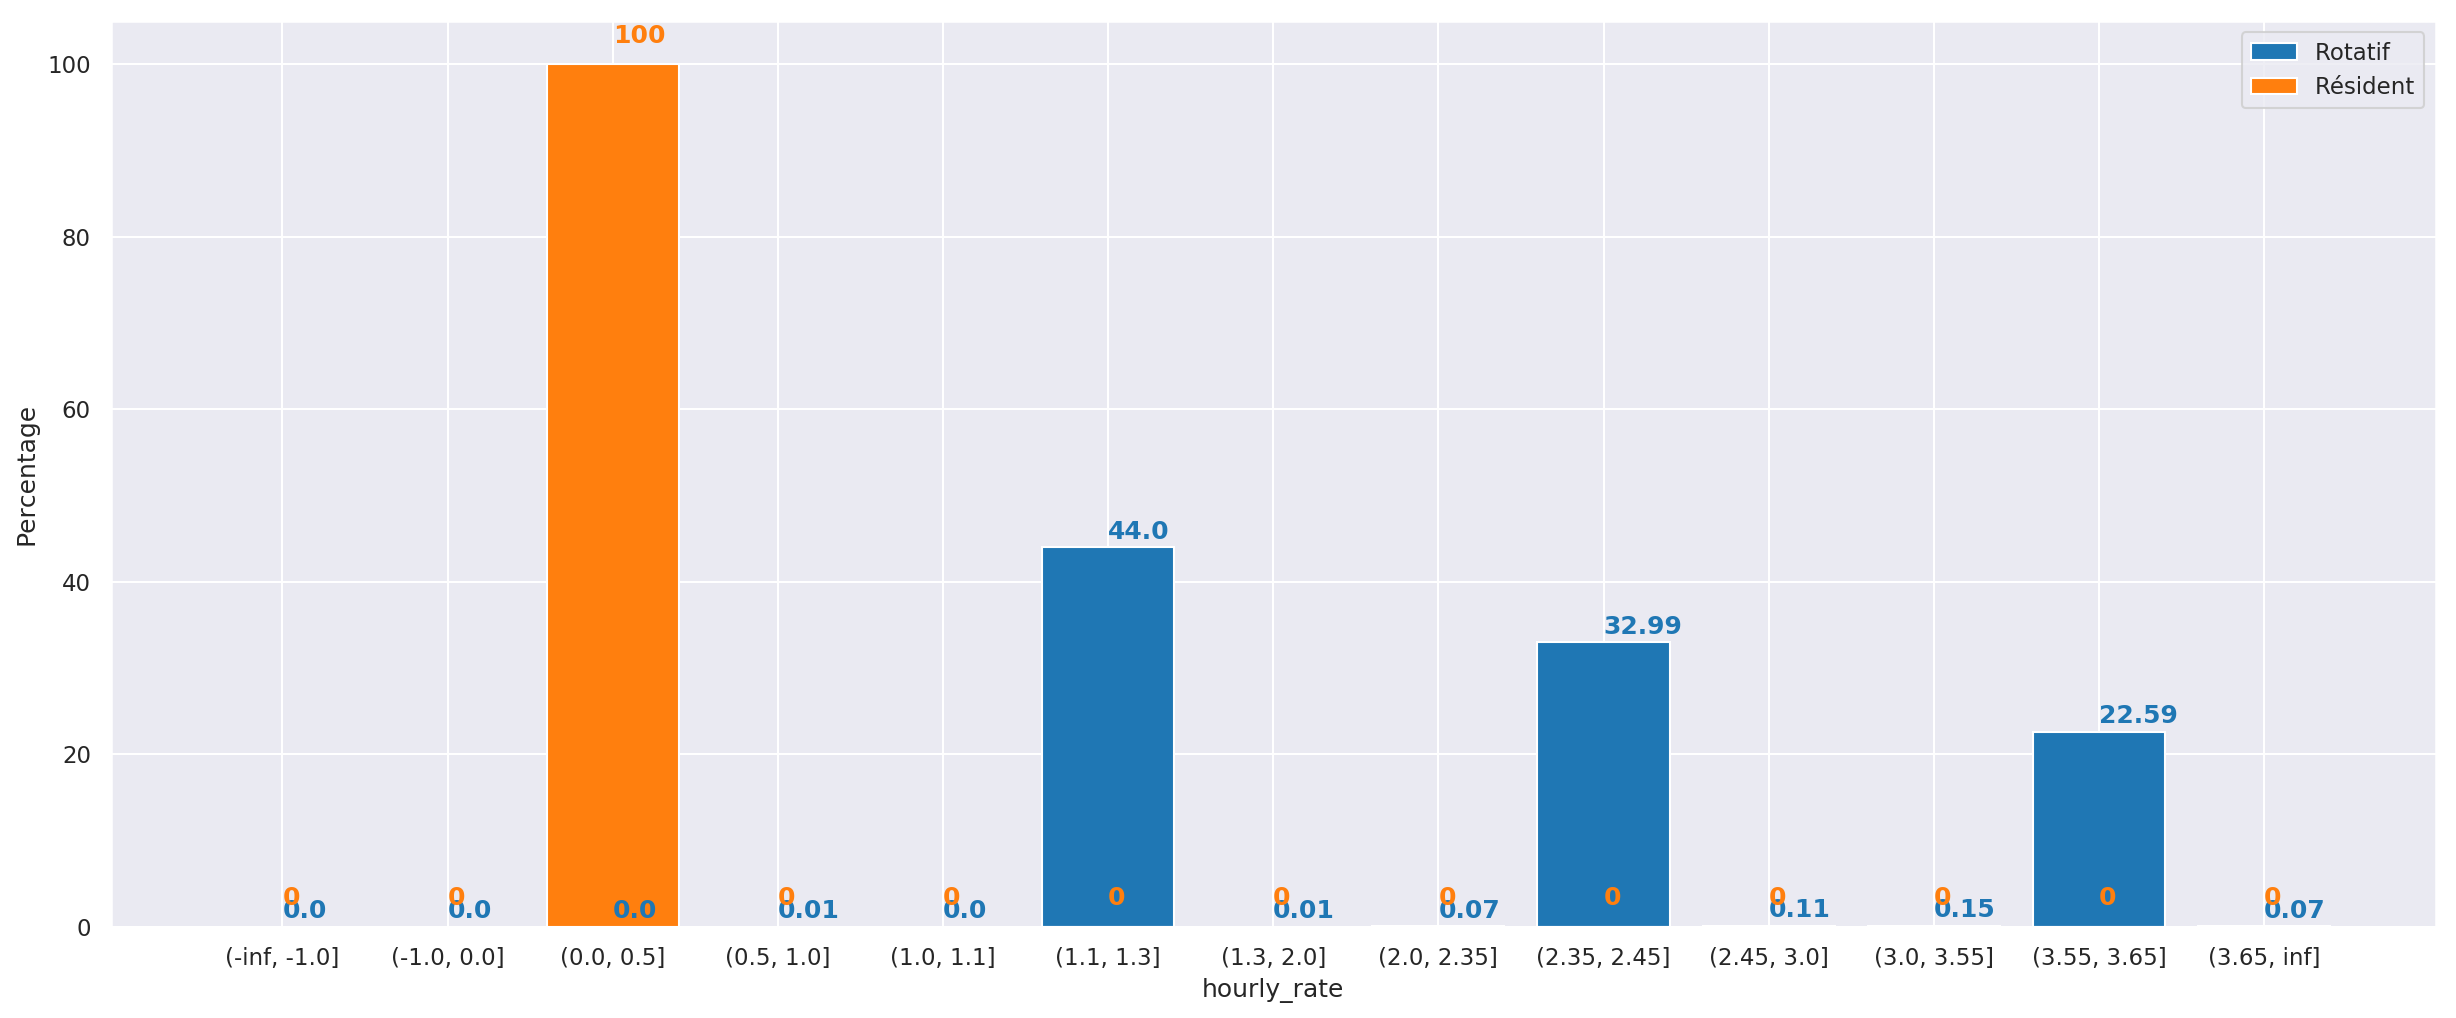

In [167]:
# Legend for the x axis
bins = [-float('inf'), -1, 0, 0.5, 1, 1.1, 1.3, 2, 2.35, 2.45, 3, 3.55, 3.65, float("inf")]

# Display the result
plotHourlyRate(sample_df, ["user_type"], "hourly_rate", bins=bins,
               save="Hourly_Rate_All")

Thanks to this graphic, it seems that the 'Rotatif' can pay three different kind of hourly rate and the Résident pay only on hourly rate.

## 4.3 - Hourly rate according to the type of user and the payment method

0.0
25.0
50.0
75.0


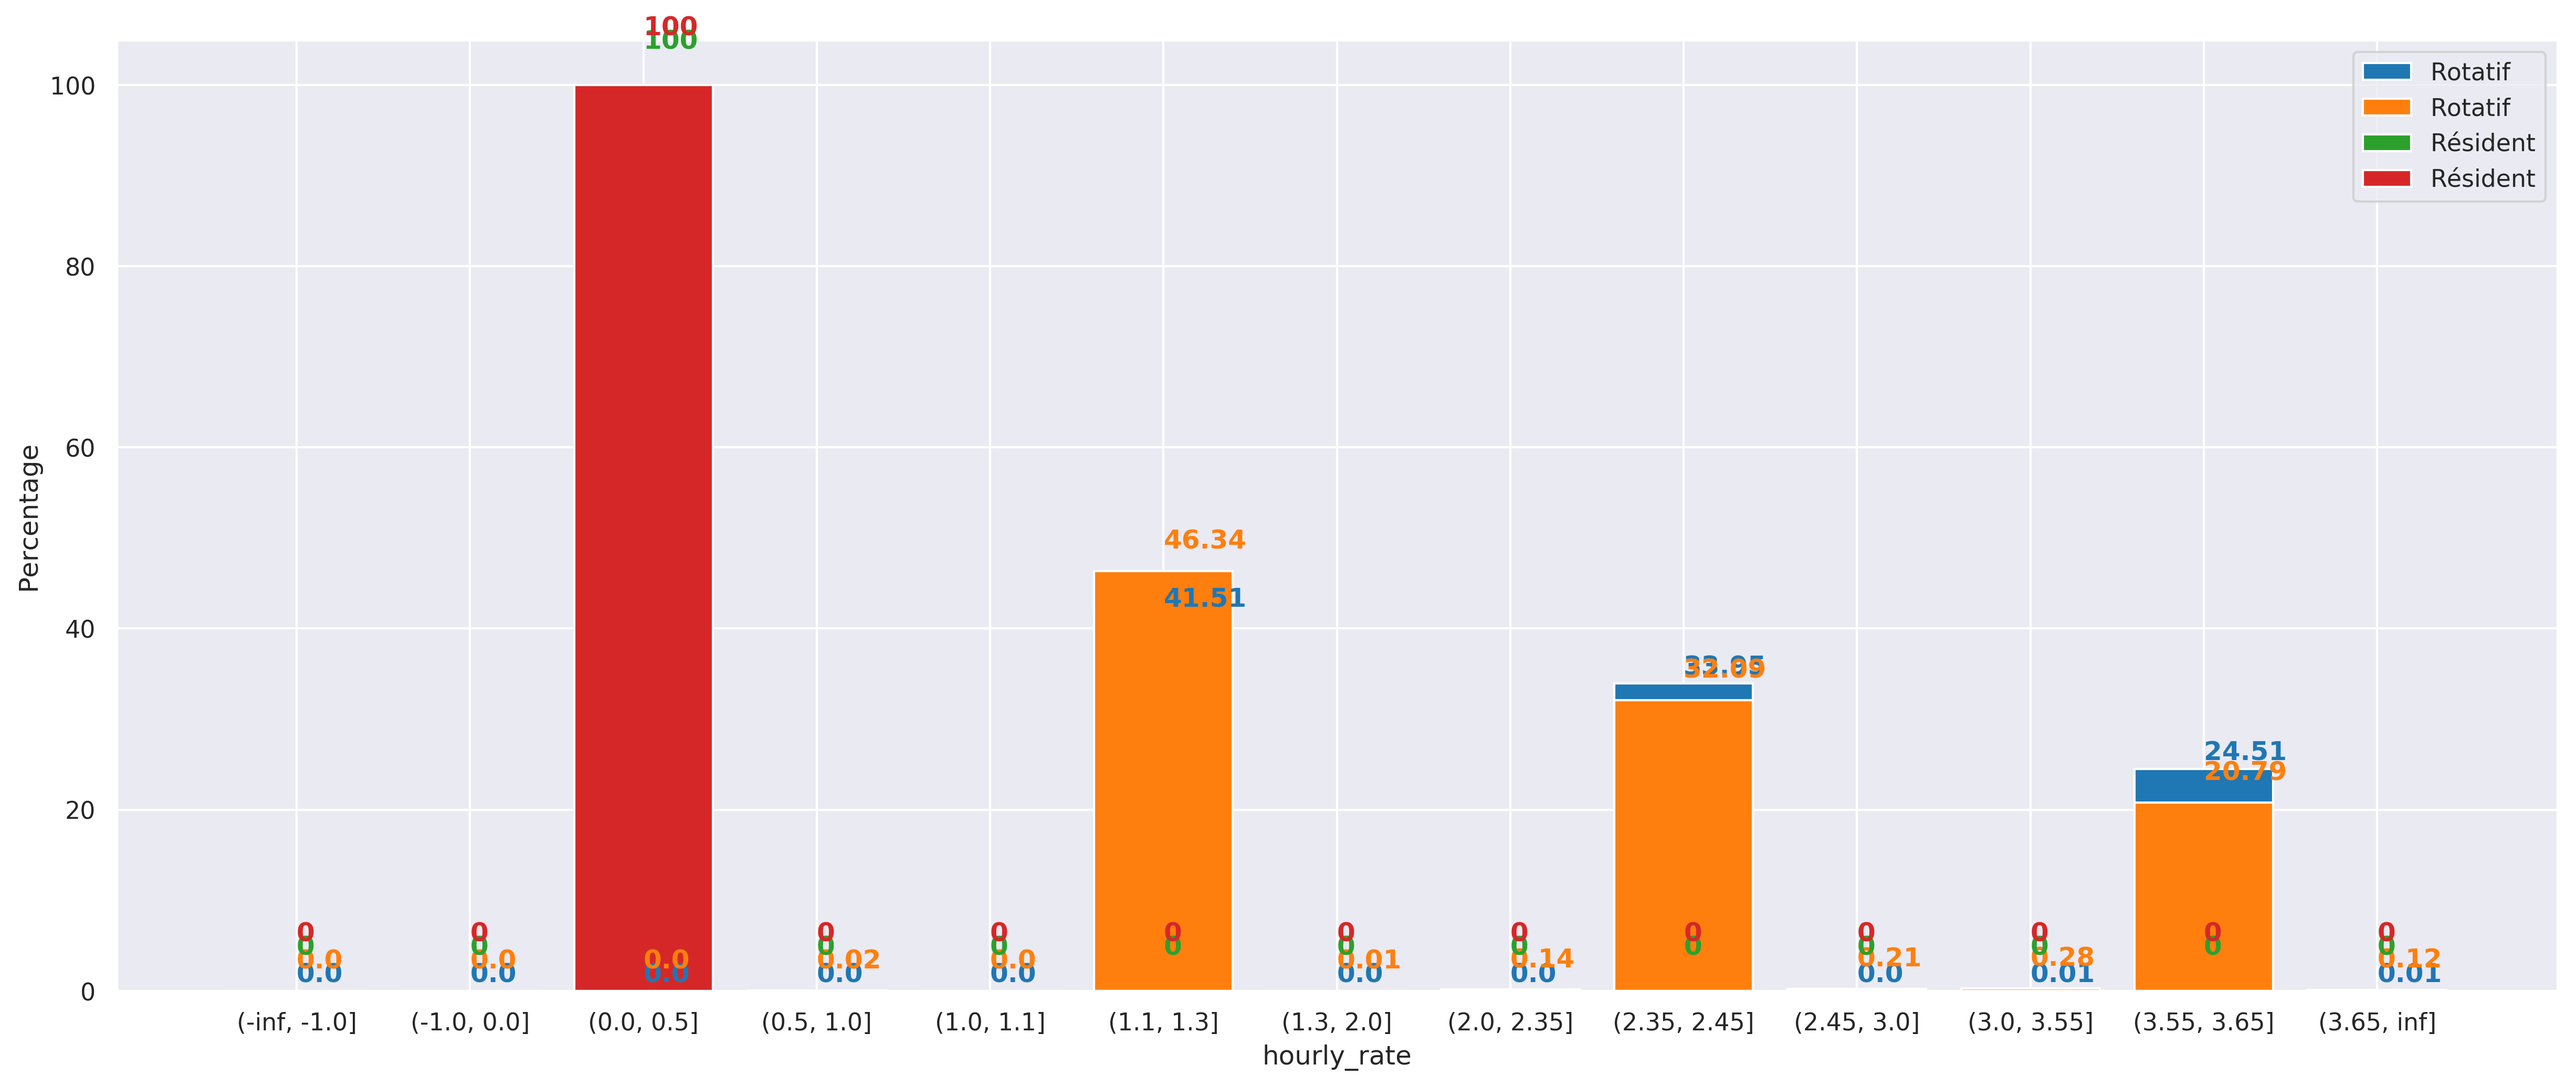

In [155]:
# Legend for the x axis
bins = [-float('inf'), -1, 0, 0.5, 1, 1.1, 1.3, 2, 2.35, 2.45, 3, 3.55, 3.65, float("inf")]

# Display the result
plotHourlyRate(sample_df, ["user_type", "payment_method"], "hourly_rate", bins=bins,
               save="Hourly_Rate_Payment_Method_All")

According to this graphic, the payment method does not influence the hourly rate and so the price paid.

## 4.4 - Duration hours according to the type of user

0.0
50.0


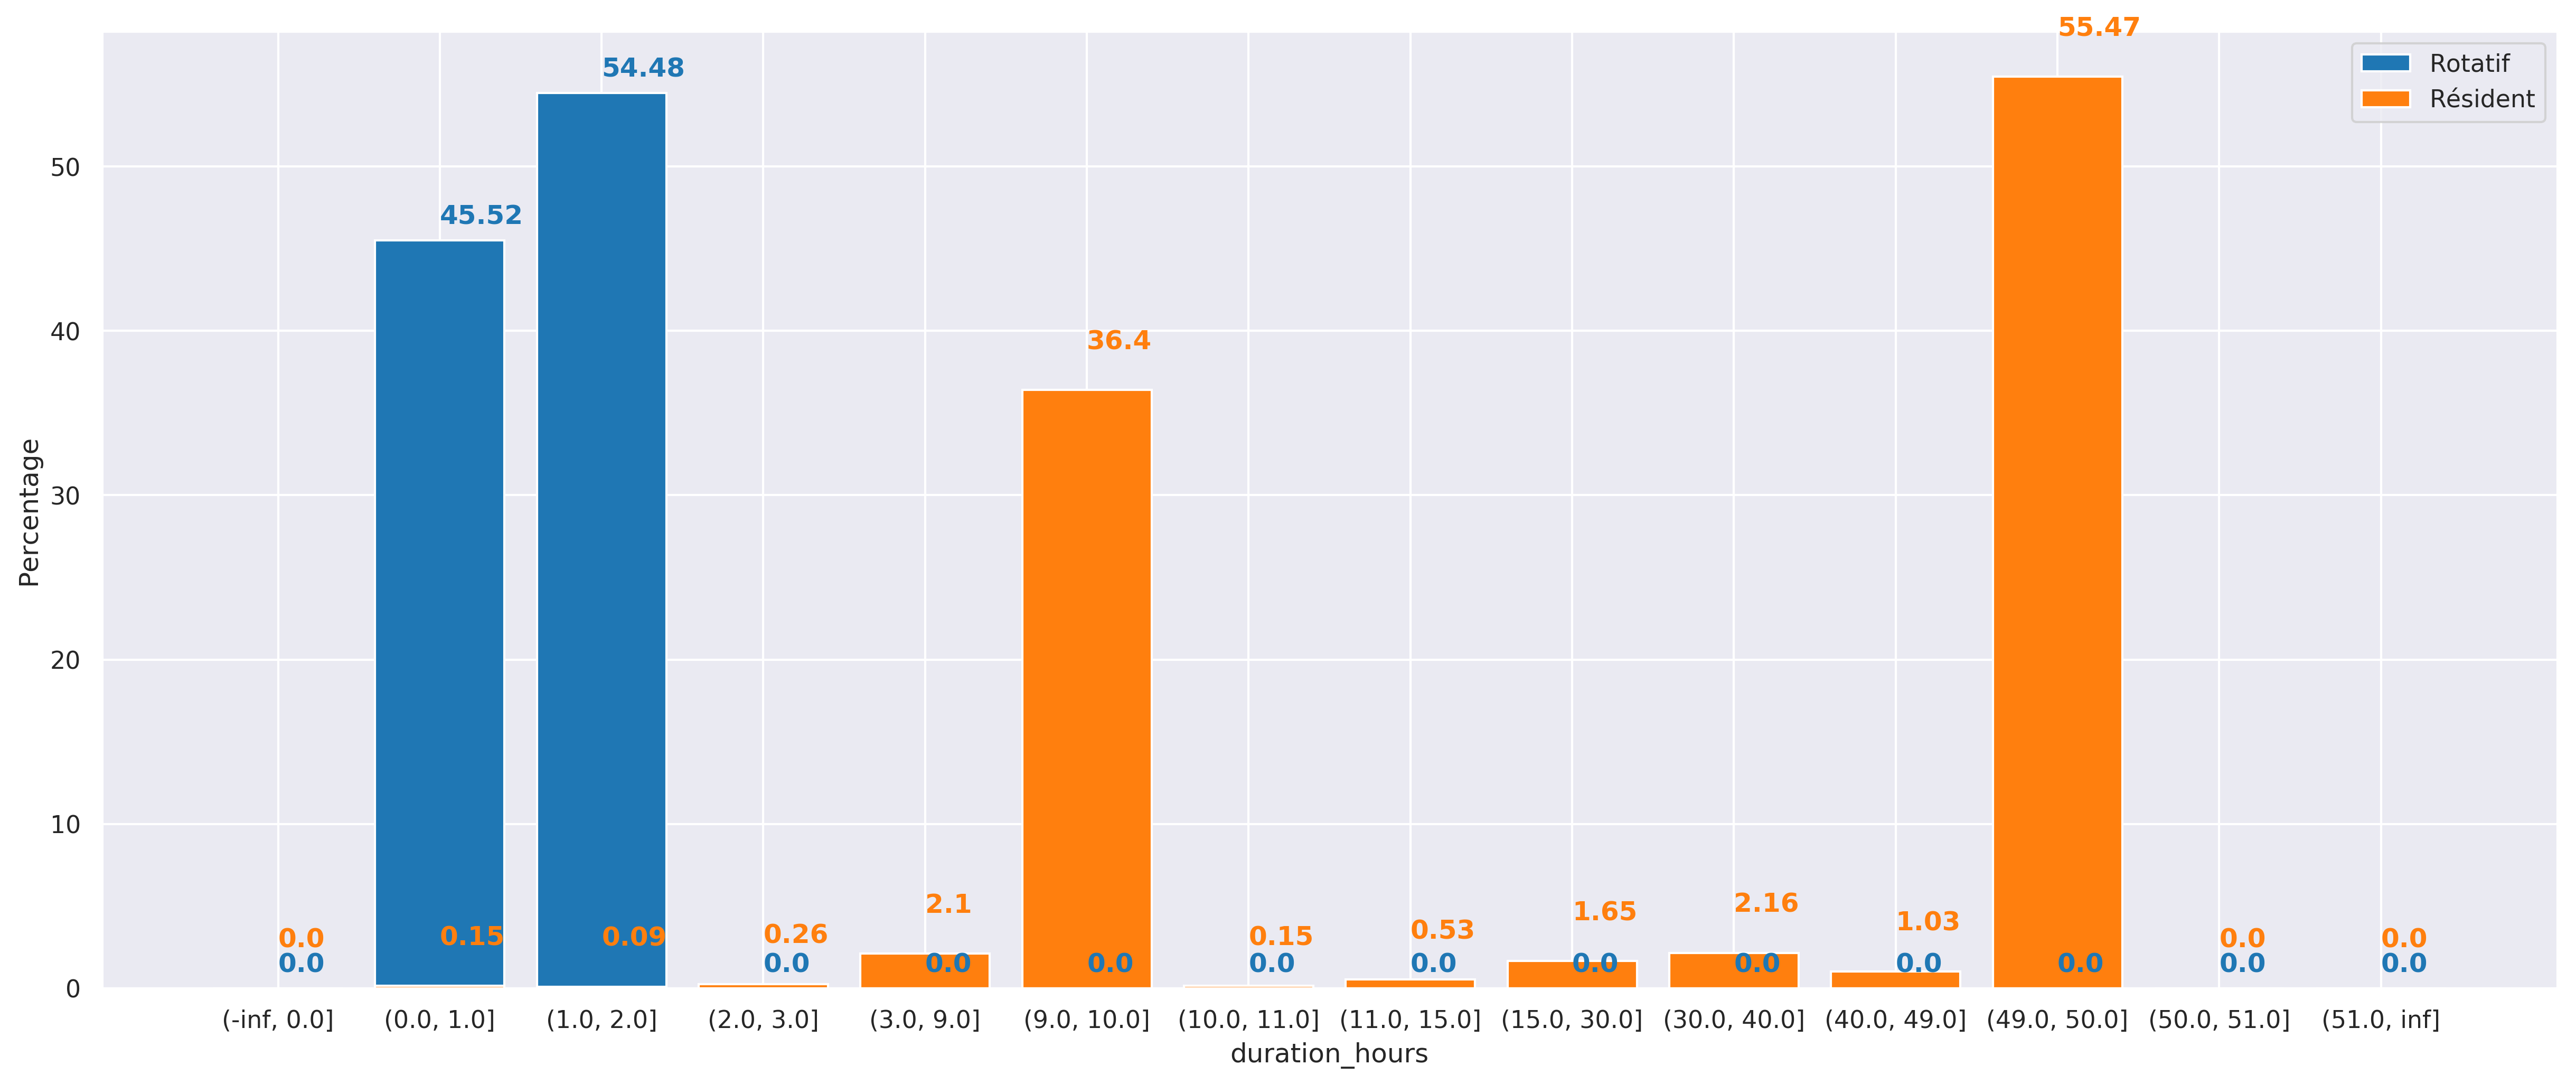

In [156]:
# Legend for the x axis
bins = [-float('inf'), 0, 1, 2, 3, 9, 10, 11, 15, 30, 40, 49, 50, 51, float('inf')]

# Display the result
plotHourlyRate(sample_df, ["user_type"], "duration_hours", bins=bins,
               save="Histogram_Duration_Hours_All")

Thanks to this graphic, we have a deeper understanding of what kind of usage the users have:
 * "Rotatif": limited below 2 hours, it is linked by the reglementation.
 * "Résident": They paid almost surely or for the day (10 hours) or for the week (50 hours)

## 4.5 - Usage of the rotatif

In [157]:
# Extract the rotatif
rotatif_df = sample_df[sample_df["user_type"] == "Rotatif"]

0.0


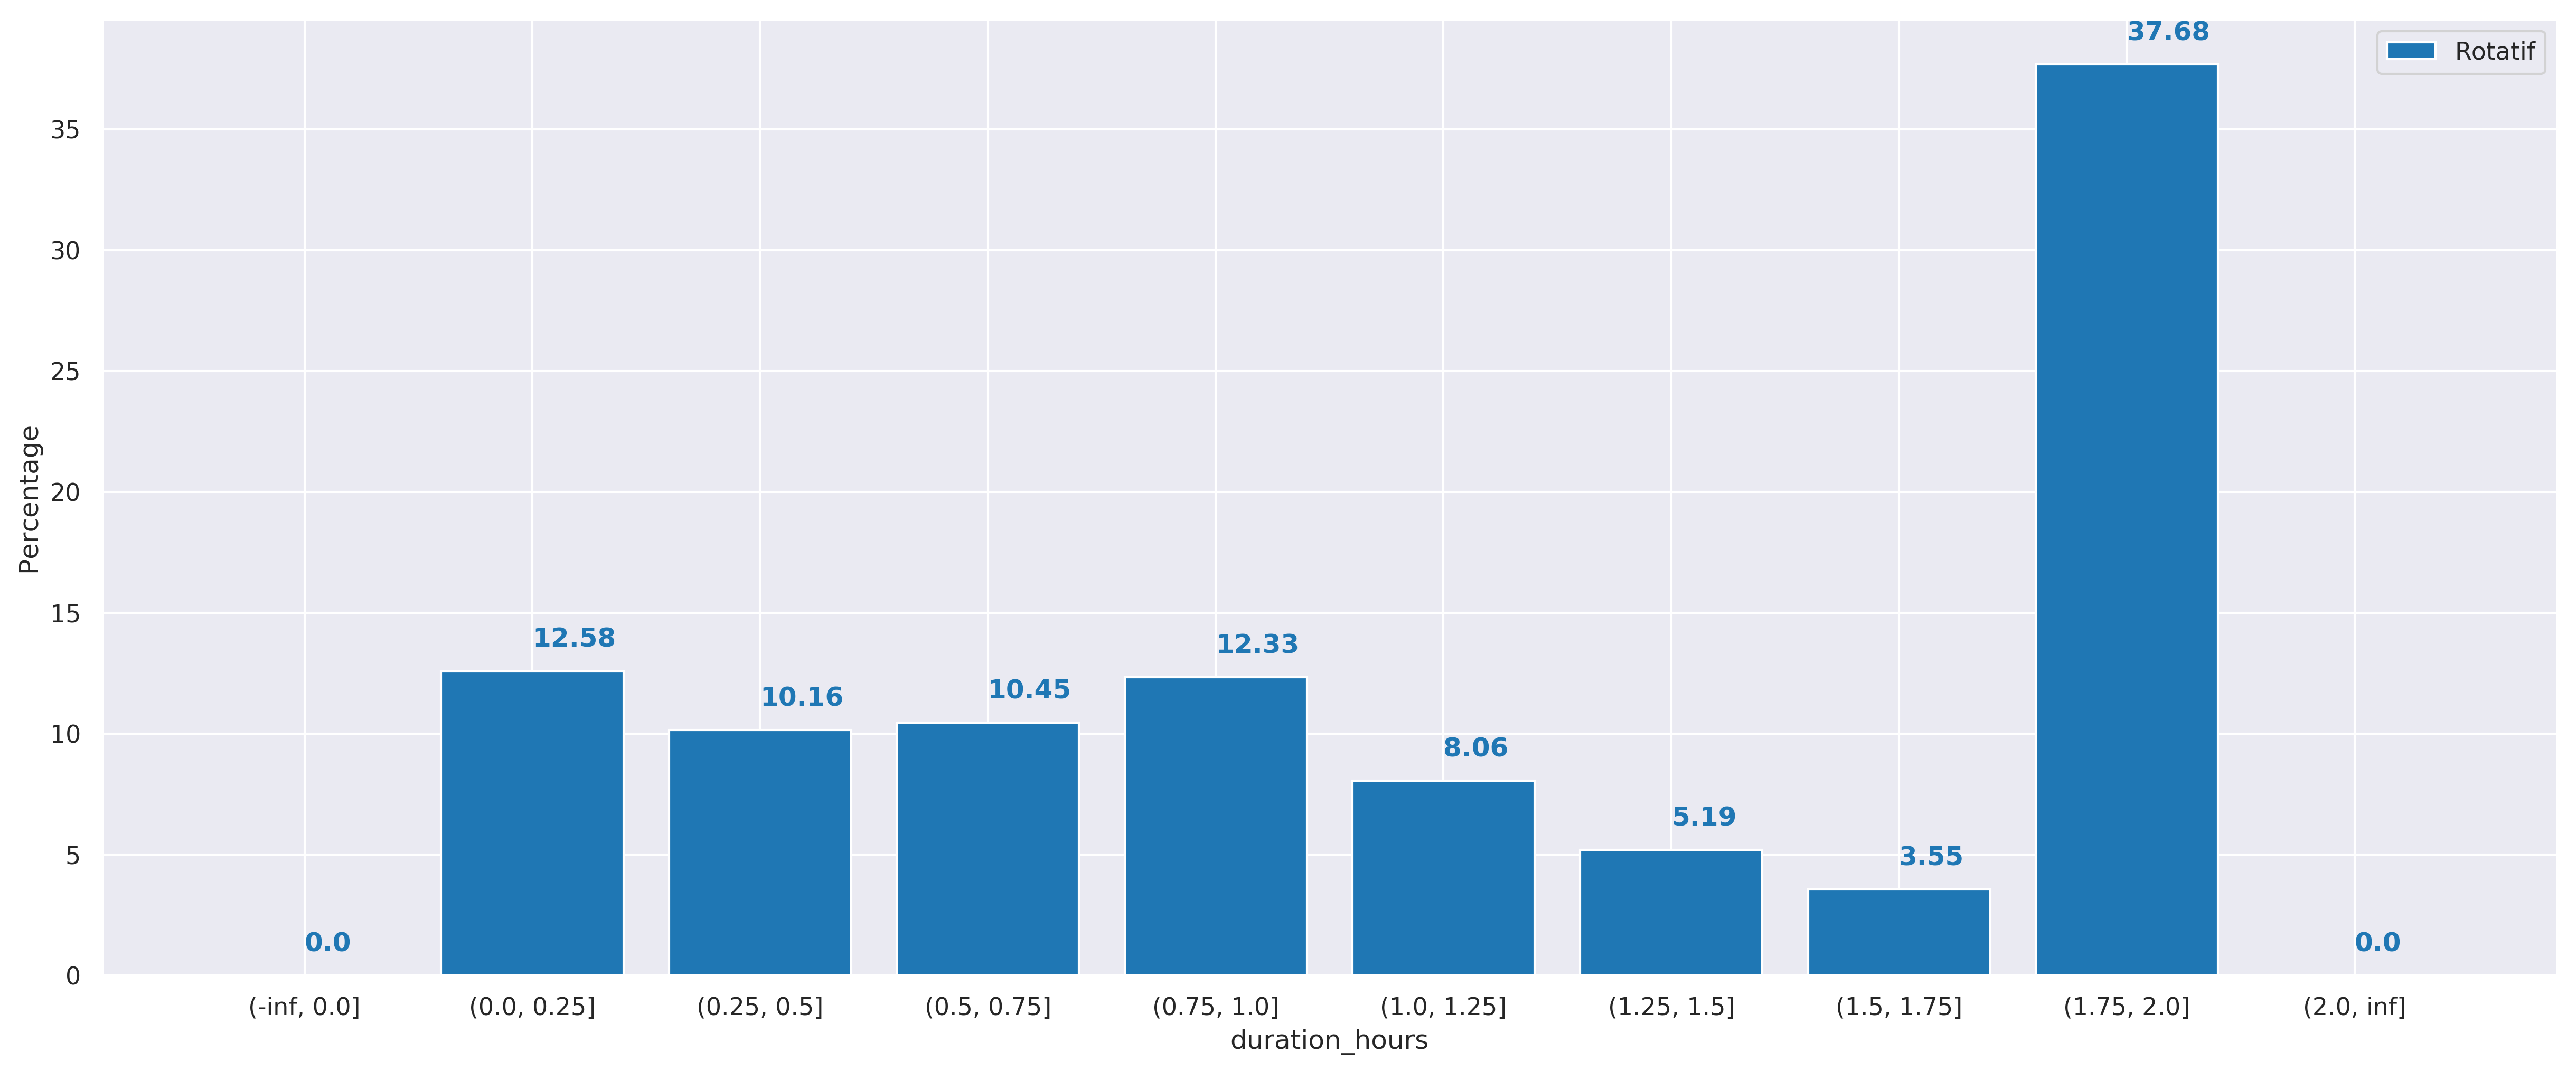

In [158]:
# Legend for the x axis
bins = [-float('inf'), 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, float('inf')]

# Display the result
plotHourlyRate(rotatif_df, ["user_type"], "duration_hours", bins=bins,
               save="Histogram_Duration_Hours_Rotatif")

# 5 - Extraction of the hourly rates

In this section, we extract the true hourly rates by computing the means.

In [159]:
# Extract the Résident values
resident_df = sample_df[sample_df["user_type"] == "Résident"]

# Extract the hourly rate of the 'Résident'
median = resident_df["hourly_rate"].median()
mean = resident_df["hourly_rate"].mean()

# Display the resul
print(mean, median)

0.06502829634346369 0.065


In [160]:
def extractHourlyRate(df):
    """Extract the three kind of hourly rates."""
    
    # Cut the dataFrame in three bins
    out_df = pd.cut(df["hourly_rate"].values, bins=[0, 1.5, 3, float('inf')])
    
    # Possible values
    bins = out_df.unique()
    
    for bin_item in bins:
        mean = df[out_df == bin_item]["hourly_rate"].mean()
        mean = round(mean, 4)
        median = df[out_df == bin_item]["hourly_rate"].median()
        median = round(median, 4)
        print("For an hourly rate paid between {} the mean is {} and the median is {}"\
              .format(bin_item, mean, median))

In [161]:
# Extract the three kind of hourly rate for the "Rotatif"
extractHourlyRate(rotatif_df)

For an hourly rate paid between (1.5, 3.0] the mean is 2.3998 and the median is 2.4
For an hourly rate paid between (0.0, 1.5] the mean is 1.1999 and the median is 1.2
For an hourly rate paid between (3.0, inf] the mean is 3.5995 and the median is 3.6


# 6 - Futher studies on the hourly rates of the rotatif

In this section, we try to understand why the hourly rate of the rotatif can be different.

In [164]:
def plotHourlyRateBy(df, column_by, save=None):
    """Displays the hourly rate according to column_by."""
    
    # Parameter of the figure
    fig, ax = plt.subplots(figsize=(8,8), dpi=150)
    plt.grid(True)
    
    # Values to plot
    column_values = df[column_by].sort_values().unique()
    grouped_df = df.groupby(column_by)
    data = []
    
    for value in column_values:
        data.append(list(grouped_df.get_group(value)["hourly_rate"].values))
    
    ax.boxplot(data, sym='')
    
    # Legend of the axes
    plt.xlabel(column_by)
    plt.ylabel("hourly_rate")
    
    # Parameters of the axes
    plt.xticks(column_values)
    plt.yticks([i * 0.6 for i in range(10)])
    
    # Save the fig
    if save != None:
        plt.savefig("./Images/Rotatif_" + save, bbox_inches='tight', pad_inches=0.0)
    else:
         plt.savefig("./Images/Rotatif_" + column_by, bbox_inches='tight', pad_inches=0.0)
        
    # Display the figure
    plt.show()

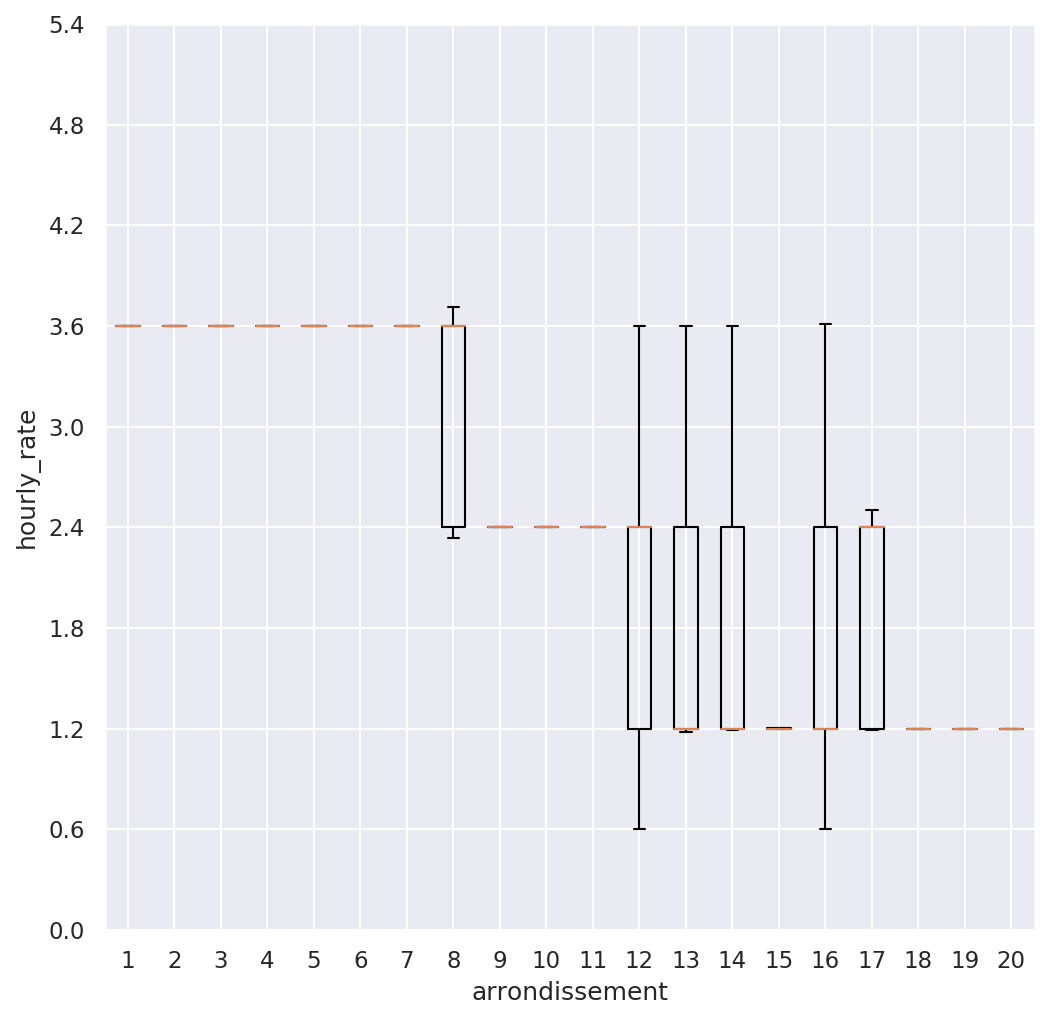

In [165]:
plotHourlyRateBy(rotatif_df, "arrondissement")

# 7 - 3D plotting

In this part, we are going to look deeper on the data, to understand better how to define a usage

In [168]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

from IPython.html.widgets  import widgets, interact
import colorlover as cl

/home/pierre/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



In [169]:
def pointsCoordinates(df, n=int(10e4)):
    """Return an array with all the traces to draw in the 3D scatter plot."""
    
    # Initialisation of the saving array
    traces = []
    
    # Set of colors
    set_colors = ['rgba(217, 217, 217, 0.14)', 'rgba(155, 120, 64, 0.14)']
    
    for i, user_type in enumerate(df["user_type"].unique()):
        
        # Extract info only for the specified user_type
        data_df = df[df["user_type"] == user_type]
            
        # Extract the coordinates
        label_x = "duration_hours"
        x = data_df[label_x].values[:n]
        label_y = "hour"
        y = data_df[label_y].values[:n]
        label_z = "arrondissement"
        z = data_df[label_z].values[:n]

        # Specifications for this trace
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            name=user_type,
            mode='markers',
            marker=dict(
                size=3,
                line=dict(
                    color=set_colors[i],
                    width=0.55
                ),
                opacity=0.8
            )
        )
        
        # Update traces list
        traces.append(trace)
        
    return traces, label_x, label_y, label_z

In [171]:
# Extract the 3D coordinates
data, label_x, label_y, label_z = pointsCoordinates(sample_df, n=1000)

# Definition of the layout
layout = go.Layout(
    scene = dict(
        xaxis = dict(
            title=label_x),
        yaxis = dict(
            title=label_y),
        zaxis = dict(
            title=label_z),),
        width=700,
        margin=dict(
        r=0,
        b=0,
        l=0,
        t=0
        )
)

# Display the data
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# 8 - Computation of the rate of occupancy

In this section, we compute the rate of occupancy for each parkmeter. For doing that we first compute the maximum of parked car over all history and then we normalize by this maximum.

## 8.1 - Extract the year-minute of the start of the parking and the ending year-minute

In [204]:
mini_df = df[["parkmeter_id", "parking_start", "parking_end"]]

In [205]:
def extractMinuteYear(dt):
    """Extract the minute of the year given by the datetime."""
    
    # Extract minute of the year
    year_minute = dt.dayofyear * 24 * 60 + dt.hour * 60 + dt.minute
    
    return year_minute

In [206]:
# Extract for each transactions the minute of the year
mini_df["YearMinute_Start"] = mini_df["parking_start"].apply(extractMinuteYear)
mini_df["YearMinute_End"] = mini_df["parking_end"].apply(extractMinuteYear)

# Display result
mini_df.head()

/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,parkmeter_id,parking_start,parking_end,YearMinute_Start,YearMinute_End
0,66391001,2014-09-09 14:02:44,2014-09-09 16:02:44,363722,363842
1,66391001,2014-02-09 14:18:09,2014-02-09 14:33:09,58458,58473
2084,66391001,2014-05-09 18:55:21,2014-05-09 19:25:21,186895,186925
2085,66391001,2014-08-09 16:30:32,2014-08-09 17:15:32,319230,319275
2086,66391001,2014-01-09 18:40:25,2014-01-09 18:55:25,14080,14095


## 8.2 - Compute the paying year-minutes

In [207]:
def indicesPayingDays(n=366*24*60):
    """Return the indices of the minutes for which users have to pay."""
    
    # Initialise array
    indices = []
    
    # First date
    init_dt = pendulum.datetime(2014, 1, 1, 0, 0, tz="Europe/Paris")
    
    # Loop over each minutes
    for i in range(n):
        
        # Add minutes i
        dt = init_dt.add(minutes=i)
        
        # Test if dt is a week day
        week_day = dt.weekday()
        if 0 <= week_day and week_day <= 4:
            
            # Test if the hour is between 9 and 20
            hour = dt.hour
            if 8 <= hour and hour <= 19:
                indices.append(i)
                
            else:
                i += 59
            
        else:
            # Add one day
            i += 24*60 - 1
        
    return indices 

In [208]:
indices_paying_day = indicesPayingDays()

## 8.3 - Compute the rate of occupancy

In [209]:
def rateOfOccupancy(df):
    """Return the mean rate of occupancy for the dataFrame df."""
    
    # Counting array representing all minutes of a year
    nb_minutes = 366 * 24 * 60
    counts = np.array([0 for i in range(nb_minutes)])
    
    # Number of example
    n = len(df)
    
    # Starting minutes
    starting_minutes = df["YearMinute_Start"].values.reshape(-1)
    ending_minutes = df["YearMinute_End"].values.reshape(-1)
    
    # Loop over each example
    for i in range(n):

        # Extract indices to changes
        minute_start = starting_minutes[i]
        minute_end = ending_minutes[i]
        
        # Add
        length = minute_end - minute_start
        if length > 0:
            counts[minute_start: minute_end] = np.add(counts[minute_start: minute_end],
                                                      np.array([1 for i in range(length)]))
    
    # Filter only the paying minutes
    counts = np.take(counts, indices_paying_day)
    
    # Return the max of the counting array and the number of occurences
    maximum = counts.max()
    
    # Select only the non null value
    rates_of_utilisation = counts / maximum * 100
    
    # Number of days to consider
    mean_rate_of_occupancy = rates_of_utilisation.mean()

    return mean_rate_of_occupancy

In [210]:
def computeRateOfOccupancy(df):
    """This function compute the rate of occupancy for each parkmeter."""
    
    # Initialisation of the resulting dataFrame
    rate_of_occupancy_df = df.groupby("parkmeter_id").apply(lambda g: 1)
    
    # Loop over each group for computing the maximum of presence
    grouped_df = df.groupby("parkmeter_id")
    nb_groups = len(grouped_df)
    
    # Number of iterations done
    iteration_done = 0
    
    for g, group_df in grouped_df:
        
        # Update the resulting dataFrame
        rate_of_occupancy_df.loc[g] = rateOfOccupancy(group_df)
    
        # Display the number of step done
        iteration_done += 1
        print(iteration_done / nb_groups * 100)
        
    return rate_of_occupancy_df

In [211]:
# Compute the maximum of presence for each parkmeter
rate_of_occupancy_df = computeRateOfOccupancy(mini_df)

0.012812299807815503
0.025624599615631006
0.03843689942344651
0.05124919923126201
0.06406149903907751
0.07687379884689302
0.08968609865470852
0.10249839846252402
0.11531069827033953
0.12812299807815503
0.14093529788597053
0.15374759769378604
0.16655989750160152
0.17937219730941703
0.19218449711723257
0.20499679692504805
0.21780909673286353
0.23062139654067906
0.24343369634849454
0.25624599615631005
0.26905829596412556
0.28187059577194107
0.2946828955797566
0.3074951953875721
0.3203074951953876
0.33311979500320305
0.3459320948110186
0.35874439461883406
0.37155669442664957
0.38436899423446513
0.39718129404228053
0.4099935938500961
0.4228058936579116
0.43561819346572705
0.4484304932735426
0.4612427930813581
0.4740550928891736
0.4868673926969891
0.49967969250480465
0.5124919923126201
0.5253042921204356
0.5381165919282511
0.5509288917360666
0.5637411915438821
0.5765534913516976
0.5893657911595132
0.6021780909673287
0.6149903907751442
0.6278026905829596
0.6406149903907752
0.6534272901985907


5.663036515054452
5.675848814862268
5.688661114670084
5.701473414477898
5.714285714285714
5.72709801409353
5.739910313901345
5.752722613709161
5.7655349135169764
5.778347213324792
5.791159513132607
5.803971812940423
5.8167841127482385
5.829596412556054
5.84240871236387
5.855221012171684
5.8680333119795005
5.880845611787316
5.893657911595131
5.906470211402947
5.9192825112107625
5.932094811018578
5.944907110826393
5.957719410634208
5.970531710442025
5.98334401024984
5.996156310057656
6.00896860986547
6.021780909673287
6.034593209481102
6.047405509288917
6.060217809096733
6.073030108904549
6.085842408712364
6.098654708520179
6.1114670083279945
6.124279308135811
6.137091607943626
6.149903907751442
6.1627162075592565
6.175528507367072
6.188340807174888
6.201153106982703
6.2139654067905195
6.226777706598335
6.23959000640615
6.252402306213965
6.265214606021781
6.278026905829597
6.290839205637412
6.303651505445227
6.3164638052530435
6.329276105060859
6.342088404868675
6.3549007046764885
6.3677

11.45419602818706
11.467008327994876
11.47982062780269
11.492632927610506
11.505445227418322
11.518257527226137
11.531069827033953
11.543882126841769
11.556694426649583
11.569506726457398
11.582319026265214
11.59513132607303
11.607943625880846
11.62075592568866
11.633568225496477
11.646380525304293
11.659192825112108
11.672005124919924
11.68481742472774
11.697629724535554
11.710442024343369
11.723254324151185
11.736066623959001
11.748878923766815
11.761691223574632
11.774503523382448
11.787315823190262
11.800128122998078
11.812940422805895
11.825752722613709
11.838565022421525
11.85137732222934
11.864189622037156
11.87700192184497
11.889814221652786
11.902626521460602
11.915438821268417
11.928251121076233
11.94106342088405
11.953875720691865
11.96668802049968
11.979500320307496
11.992312620115312
12.005124919923125
12.01793721973094
12.030749519538757
12.043561819346573
12.056374119154388
12.069186418962204
12.08199871877002
12.094811018577834
12.10762331838565
12.120435618193467
12.13

17.053171044202433
17.06598334401025
17.078795643818065
17.09160794362588
17.104420243433697
17.117232543241514
17.130044843049326
17.142857142857142
17.15566944266496
17.168481742472775
17.18129404228059
17.194106342088407
17.20691864189622
17.219730941704036
17.232543241511852
17.245355541319668
17.258167841127484
17.2709801409353
17.283792440743113
17.29660474055093
17.309417040358742
17.322229340166558
17.335041639974374
17.34785393978219
17.360666239590007
17.373478539397823
17.386290839205635
17.39910313901345
17.411915438821268
17.424727738629084
17.4375400384369
17.450352338244716
17.463164638052532
17.475976937860345
17.48878923766816
17.501601537475977
17.514413837283794
17.52722613709161
17.540038436899426
17.55285073670724
17.565663036515055
17.57847533632287
17.591287636130684
17.6040999359385
17.616912235746316
17.629724535554132
17.64253683536195
17.65534913516976
17.668161434977577
17.680973734785393
17.69378603459321
17.706598334401026
17.71941063420884
17.732222934016

22.70339525944907
22.716207559256887
22.729019859064703
22.74183215887252
22.754644458680335
22.76745675848815
22.780269058295964
22.793081358103777
22.805893657911593
22.81870595771941
22.831518257527225
22.84433055733504
22.857142857142858
22.869955156950674
22.882767456758486
22.895579756566303
22.90839205637412
22.921204356181935
22.93401665598975
22.946828955797567
22.95964125560538
22.972453555413196
22.985265855221012
22.99807815502883
23.010890454836645
23.02370275464446
23.036515054452273
23.04932735426009
23.062139654067906
23.074951953875722
23.087764253683538
23.10057655349135
23.113388853299167
23.126201153106983
23.139013452914796
23.151825752722612
23.164638052530428
23.177450352338244
23.19026265214606
23.203074951953877
23.215887251761693
23.228699551569505
23.24151185137732
23.254324151185138
23.267136450992954
23.27994875080077
23.292761050608586
23.3055733504164
23.318385650224215
23.33119795003203
23.344010249839847
23.356822549647664
23.36963484945548
23.382447149

28.35361947469571
28.366431774503525
28.379244074311337
28.392056374119157
28.40486867392697
28.41768097373479
28.430493273542602
28.443305573350415
28.45611787315823
28.468930172966044
28.481742472773863
28.494554772581676
28.507367072389496
28.52017937219731
28.532991672005124
28.545803971812937
28.558616271620757
28.57142857142857
28.58424087123639
28.5970531710442
28.609865470852018
28.622677770659834
28.63549007046765
28.648302370275463
28.661114670083283
28.673926969891095
28.68673926969891
28.699551569506728
28.712363869314544
28.725176169122356
28.737988468930176
28.75080076873799
28.7636130685458
28.77642536835362
28.789237668161434
28.80204996796925
28.814862267777062
28.827674567584882
28.840486867392695
28.853299167200515
28.866111467008327
28.878923766816143
28.891736066623956
28.904548366431776
28.91736066623959
28.930172966047408
28.94298526585522
28.955797565663037
28.968609865470853
28.98142216527867
28.994234465086482
29.0070467648943
29.019859064702114
29.03267136450

34.042280589365795
34.05509288917361
34.06790518898142
34.08071748878923
34.09352978859705
34.106342088404865
34.119154388212685
34.1319666880205
34.14477898782832
34.15759128763613
34.17040358744395
34.18321588725176
34.19602818705958
34.208840486867395
34.22165278667521
34.23446508648303
34.24727738629084
34.26008968609865
34.272901985906465
34.285714285714285
34.2985265855221
34.31133888532992
34.32415118513773
34.33696348494555
34.34977578475336
34.36258808456118
34.375400384368994
34.388212684176814
34.40102498398463
34.41383728379244
34.42664958360025
34.43946188340807
34.452274183215884
34.465086483023704
34.47789878283152
34.490711082639336
34.50352338244715
34.51633568225497
34.52914798206278
34.5419602818706
34.554772581678414
34.567584881486226
34.580397181294046
34.59320948110186
34.60602178090967
34.618834080717484
34.631646380525304
34.644458680333116
34.657270980140936
34.67008327994875
34.68289557975657
34.69570787956438
34.7085201793722
34.72133247918001
34.73414477898

39.80781550288277
39.82062780269058
39.83344010249839
39.84625240230621
39.859064702114026
39.871877001921845
39.88468930172966
39.89750160153748
39.91031390134529
39.92312620115311
39.93593850096092
39.94875080076874
39.961563100576555
39.97437540038437
39.98718770019218
40.0
40.01281229980781
40.02562459961563
40.038436899423445
40.051249199231265
40.06406149903908
40.07687379884689
40.08968609865471
40.10249839846252
40.11531069827034
40.128122998078155
40.140935297885974
40.15374759769379
40.1665598975016
40.17937219730941
40.19218449711723
40.204996796925045
40.217809096732864
40.23062139654068
40.2434336963485
40.25624599615631
40.26905829596413
40.28187059577194
40.29468289557976
40.307495195387574
40.32030749519539
40.3331197950032
40.34593209481102
40.35874439461883
40.371556694426644
40.384368994234464
40.39718129404228
40.409993593850096
40.42280589365791
40.43561819346573
40.44843049327354
40.46124279308136
40.474055092889174
40.48686739269699
40.499679692504806
40.51249199

45.586162716207554
45.59897501601537
45.611787315823186
45.624599615631006
45.63741191543882
45.65022421524664
45.66303651505445
45.67584881486227
45.68866111467008
45.7014734144779
45.714285714285715
45.72709801409353
45.73991031390135
45.75272261370916
45.76553491351697
45.77834721332479
45.791159513132605
45.803971812940425
45.81678411274824
45.82959641255606
45.84240871236387
45.85522101217169
45.8680333119795
45.880845611787315
45.893657911595135
45.90647021140295
45.91928251121076
45.93209481101857
45.94490711082639
45.957719410634205
45.970531710442025
45.98334401024984
45.99615631005766
46.00896860986547
46.02178090967329
46.0345932094811
46.04740550928892
46.060217809096734
46.07303010890455
46.08584240871237
46.09865470852018
46.11146700832799
46.12427930813581
46.137091607943624
46.149903907751444
46.16271620755926
46.175528507367076
46.18834080717489
46.2011531069827
46.21396540679052
46.226777706598334
46.239590006406154
46.252402306213966
46.26521460602178
46.278026905829

51.351697629724534
51.36450992953235
51.37732222934016
51.39013452914798
51.4029468289558
51.41575912876362
51.42857142857142
51.44138372837924
51.45419602818706
51.467008327994876
51.47982062780269
51.4926329276105
51.50544522741832
51.51825752722614
51.531069827033946
51.543882126841766
51.556694426649585
51.569506726457405
51.58231902626521
51.59513132607303
51.60794362588085
51.62075592568867
51.633568225496475
51.646380525304295
51.65919282511211
51.67200512491993
51.68481742472773
51.69762972453555
51.71044202434337
51.72325432415118
51.736066623959
51.74887892376682
51.76169122357464
51.77450352338244
51.78731582319026
51.80012812299808
51.812940422805895
51.82575272261371
51.83856502242152
51.85137732222934
51.86418962203716
51.877001921844965
51.889814221652784
51.902626521460604
51.915438821268424
51.92825112107623
51.94106342088405
51.95387572069187
51.96668802049969
51.979500320307494
51.992312620115314
52.00512491992313
52.01793721973094
52.03074951953875
52.04356181934657

57.13004484304933
57.14285714285714
57.15566944266496
57.16848174247278
57.1812940422806
57.1941063420884
57.20691864189622
57.219730941704036
57.23254324151185
57.24535554131967
57.25816784112748
57.2709801409353
57.283792440743106
57.296604740550926
57.309417040358746
57.322229340166565
57.33504163997437
57.34785393978219
57.36066623959001
57.37347853939782
57.386290839205635
57.399103139013455
57.41191543882127
57.42472773862909
57.43754003843689
57.45035233824471
57.46316463805253
57.47597693786035
57.48878923766816
57.50160153747598
57.5144138372838
57.5272261370916
57.54003843689942
57.55285073670724
57.565663036515055
57.57847533632287
57.59128763613069
57.6040999359385
57.61691223574632
57.629724535554125
57.642536835361945
57.655349135169764
57.668161434977584
57.68097373478539
57.69378603459321
57.70659833440103
57.71941063420884
57.732222934016654
57.745035233824474
57.75784753363229
57.77065983344011
57.78347213324791
57.79628443305573
57.80909673286355
57.82190903267136
57

62.92120435618194
62.93401665598976
62.946828955797564
62.95964125560538
62.972453555413196
62.985265855221016
62.99807815502882
63.01089045483664
63.02370275464446
63.036515054452266
63.049327354260086
63.062139654067906
63.074951953875726
63.08776425368353
63.10057655349135
63.11338885329917
63.12620115310699
63.139013452914796
63.151825752722615
63.16463805253043
63.17745035233825
63.19026265214605
63.20307495195387
63.21588725176169
63.22869955156951
63.24151185137732
63.25432415118514
63.26713645099296
63.27994875080078
63.29276105060858
63.3055733504164
63.318385650224215
63.33119795003203
63.34401024983984
63.35682254964766
63.36963484945548
63.382447149263285
63.395259449071105
63.408071748878925
63.420884048686744
63.43369634849455
63.44650864830237
63.45932094811019
63.47213324791801
63.484945547725815
63.497757847533634
63.51057014734145
63.52338244714927
63.53619474695707
63.54900704676489
63.56181934657271
63.57463164638053
63.58744394618834
63.60025624599616
63.6130685458

68.77642536835363
68.78923766816143
68.80204996796925
68.81486226777707
68.82767456758488
68.8404868673927
68.8532991672005
68.86611146700832
68.87892376681614
68.89173606662395
68.90454836643177
68.91736066623959
68.93017296604741
68.94298526585521
68.95579756566303
68.96860986547085
68.98142216527867
68.99423446508648
69.0070467648943
69.01985906470212
69.03267136450994
69.04548366431774
69.05829596412556
69.07110826393338
69.0839205637412
69.09673286354901
69.10954516335683
69.12235746316465
69.13516976297245
69.14798206278027
69.16079436258809
69.1736066623959
69.18641896220372
69.19923126201152
69.21204356181934
69.22485586162716
69.23766816143497
69.25048046124279
69.26329276105061
69.27610506085843
69.28891736066623
69.30172966047405
69.31454196028187
69.32735426008969
69.3401665598975
69.35297885970532
69.36579115951314
69.37860345932096
69.39141575912876
69.40422805893658
69.4170403587444
69.4298526585522
69.44266495836003
69.45547725816785
69.46828955797567
69.48110185778347


74.67008327994876
74.68289557975658
74.69570787956438
74.7085201793722
74.72133247918002
74.73414477898783
74.74695707879565
74.75976937860345
74.77258167841127
74.78539397821909
74.7982062780269
74.81101857783472
74.82383087764254
74.83664317745036
74.84945547725816
74.86226777706598
74.8750800768738
74.88789237668162
74.90070467648943
74.91351697629725
74.92632927610506
74.93914157591287
74.95195387572069
74.96476617552851
74.97757847533633
74.99039077514414
75.00320307495195
75.01601537475977
75.0288276745676
75.0416399743754
75.05445227418322
75.06726457399104
75.08007687379884
75.09288917360666
75.10570147341447
75.11851377322229
75.13132607303011
75.14413837283792
75.15695067264573
75.16976297245355
75.18257527226137
75.19538757206918
75.208199871877
75.22101217168482
75.23382447149262
75.24663677130044
75.25944907110826
75.27226137091608
75.28507367072389
75.29788597053171
75.31069827033953
75.32351057014735
75.33632286995515
75.34913516976297
75.3619474695708
75.37475976937861


80.56374119154388
80.5765534913517
80.58936579115952
80.60217809096733
80.61499039077515
80.62780269058297
80.64061499039077
80.6534272901986
80.6662395900064
80.67905188981422
80.69186418962204
80.70467648942984
80.71748878923766
80.73030108904548
80.74311338885329
80.75592568866111
80.76873798846893
80.78155028827675
80.79436258808455
80.80717488789237
80.81998718770019
80.83279948750801
80.84561178731582
80.85842408712364
80.87123638693146
80.88404868673928
80.89686098654708
80.9096732863549
80.92248558616272
80.93529788597054
80.94811018577835
80.96092248558617
80.97373478539399
80.98654708520179
80.99935938500961
81.01217168481742
81.02498398462524
81.03779628443306
81.05060858424086
81.06342088404868
81.0762331838565
81.08904548366431
81.10185778347213
81.11467008327995
81.12748238308777
81.14029468289557
81.15310698270339
81.16591928251121
81.17873158231903
81.19154388212684
81.20435618193466
81.21716848174248
81.2299807815503
81.2427930813581
81.25560538116592
81.26841768097374

86.45739910313901
86.47021140294683
86.48302370275465
86.49583600256247
86.50864830237028
86.5214606021781
86.53427290198591
86.54708520179372
86.55989750160154
86.57270980140936
86.58552210121717
86.59833440102499
86.61114670083279
86.62395900064061
86.63677130044843
86.64958360025624
86.66239590006406
86.67520819987188
86.6880204996797
86.7008327994875
86.71364509929532
86.72645739910314
86.73926969891096
86.75208199871877
86.76489429852658
86.7777065983344
86.79051889814222
86.80333119795003
86.81614349775785
86.82895579756567
86.84176809737349
86.8545803971813
86.86739269698911
86.88020499679693
86.89301729660474
86.90582959641256
86.91864189622038
86.93145419602818
86.944266495836
86.95707879564381
86.96989109545163
86.98270339525945
86.99551569506725
87.00832799487507
87.0211402946829
87.03395259449071
87.04676489429852
87.05957719410634
87.07238949391416
87.08520179372198
87.09801409352978
87.1108263933376
87.12363869314542
87.13645099295324
87.14926329276105
87.16207559256887
8

92.35105701473415
92.36386931454196
92.37668161434978
92.3894939141576
92.4023062139654
92.41511851377322
92.42793081358104
92.44074311338886
92.45355541319667
92.46636771300449
92.47918001281231
92.49199231262011
92.50480461242793
92.51761691223575
92.53042921204356
92.54324151185138
92.55605381165918
92.568866111467
92.58167841127482
92.59449071108264
92.60730301089045
92.62011531069827
92.63292761050609
92.6457399103139
92.65855221012171
92.67136450992953
92.68417680973735
92.69698910954516
92.70980140935298
92.7226137091608
92.73542600896862
92.74823830877642
92.76105060858424
92.77386290839206
92.78667520819988
92.79948750800769
92.8122998078155
92.82511210762333
92.83792440743113
92.85073670723895
92.86354900704677
92.87636130685458
92.8891736066624
92.9019859064702
92.91479820627802
92.92761050608584
92.94042280589366
92.95323510570147
92.96604740550929
92.9788597053171
92.99167200512491
93.00448430493273
93.01729660474055
93.03010890454837
93.04292120435618
93.055733504164
93.0

98.24471492632928
98.25752722613709
98.2703395259449
98.28315182575273
98.29596412556054
98.30877642536835
98.32158872517617
98.33440102498399
98.34721332479181
98.36002562459961
98.37283792440743
98.38565022421525
98.39846252402307
98.41127482383088
98.4240871236387
98.4368994234465
98.44971172325432
98.46252402306213
98.47533632286995
98.48814862267777
98.50096092248558
98.5137732222934
98.52658552210121
98.53939782190903
98.55221012171684
98.56502242152466
98.57783472133248
98.5906470211403
98.6034593209481
98.61627162075592
98.62908392056374
98.64189622037156
98.65470852017937
98.66752081998719
98.68033311979501
98.69314541960283
98.70595771941063
98.71877001921845
98.73158231902627
98.7443946188341
98.7572069186419
98.77001921844972
98.78283151825752
98.79564381806534
98.80845611787315
98.82126841768097
98.83408071748879
98.8468930172966
98.85970531710441
98.87251761691223
98.88532991672005
98.89814221652786
98.91095451633568
98.9237668161435
98.93657911595132
98.94939141575912
98

In [212]:
# Display some results
print("Maximum mean rate of occupancy: ", rate_of_occupancy_df.max())
print("Mean of rate of occupancy over all parkmeters: ", rate_of_occupancy_df.mean())

# Save the results in a csv
rate_of_occupancy_df.to_csv("Rate_Of_Occupancy.csv")

Maximum rate of occupancy:  68.51766546752069
Mean of rate of occupancy over all parkmeters:  55.42402040218169


# 10 - Studies a the number of transaction during the week end

In [47]:
def extractWeekDay(date):
    """Extract the week day contains in date."""
    
    # List of days
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    # Extract the week day
    week_day = date.weekday()
    
    return days[week_day]

In [48]:
# Add the kind of day to the dataset
sample_df["WeekDay"] = sample_df["parking_start"].apply(extractWeekDay)

# Display the result
sample_df.head()

,parkmeter_id,user_type,payment_method,amount,duration_hours,parking_start,parking_end,parkmeter_address,arrondissement,system,residential_area,hourly_rate,parkmeter_coordinates,hour,WeekDay
23748808,74940301,Rotatif,CB,1.20,0.50,2014-02-10 09:43:43,2014-02-10 10:30:00,16 vis-à-vis RUE PINEL,13,MIX,13K,2.400,"48.8339759996, 2.35946099948",9,Monday
5813731,30981301,Rotatif,CB,4.50,1.25,2014-08-04 13:27:33,2014-08-04 14:42:33,53 RUE DES ECOLES,5,MIX,5J,3.600,"48.850117, 2.34289799976",13,Monday
19538348,69980102,Rotatif,CB,5.40,1.50,2014-12-11 08:05:21,2014-12-11 11:30:00,6 RUE DE LA PAIX,2,ROT,2E,3.600,"48.8686159998, 2.33071299962",8,Thursday
2254086,51220602,Rotatif,Paris Carte,4.80,2.00,2014-07-24 18:18:05,2014-07-24 20:18:05,42 AVENUE JUNOT,18,MIX,18F,2.400,"48.8893400003, 2.33772599993",18,Thursday
12027879,78020206,Résident,CB,3.25,50.00,2014-02-03 13:37:44,2014-07-03 21:00:00,10 vis-à-vis PLACE DU PRESIDENT MITHOUARD,7,MIX,7K,0.065,"48.8508600004, 2.31275399954",13,Monday


In [49]:
# Select only the data for people arriving the week end
n = len(sample_df)
weekend_df = sample_df[sample_df["WeekDay"].apply(lambda x: x in ["Saturday", "Sunday"])]
print(len(weekend_df) / n * 100)

14.287988065132119


In [50]:
week_df = sample_df[sample_df["WeekDay"].apply(lambda x: not(x in ["Saturday", "Sunday"]))]

night_df = week_df[week_df["hour"].apply(lambda x: x >= 20 or x < 8)]
print(len(night_df) / n)

0.07458096631030574


In [60]:
def hour_night(x):
    
    if x < 20:
        return x
    else:
        return (4 - (x % 20)) + 8

In [70]:
# Extract rotatif
rotatif_df = df[df["user_type"] == "Rotatif"]

# Add week day to rotatif
rotatif_df["WeekDay"] = rotatif_df["parking_start"].apply(extractWeekDay)

# Extract hour
rotatif_df["hour"] = rotatif_df["parking_start"].apply(lambda x: x.hour)

# Extract week days for rotatif
week_r_df = rotatif_df[rotatif_df["WeekDay"].apply(lambda x: not(x in ["Saturday", "Sunday"]))]

# Extract night of the week of the rotatif
night_r_df = week_r_df[week_r_df["hour"].apply(lambda x: x >= 20 or x < 8)]

/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
# Extract the number of hours that the rotatif stay the night
night_r_df["night_hour"] = night_df["hour"].apply(hour_night)

/home/pierre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
night_r_df["hour"].sum() / len(night_r_df)

13.861544809574047

In [73]:
len(night_r_df)

661622

In [74]:
rotatif_df.columns

Index(['parkmeter_id', 'user_type', 'payment_method', 'amount',
       'duration_hours', 'parking_start', 'parking_end', 'parkmeter_address',
       'arrondissement', 'system', 'residential_area', 'hourly_rate',
       'parkmeter_coordinates', 'WeekDay', 'hour'],
      dtype='object')

In [75]:
rotatif_2h_df = rotatif_df[rotatif_df["duration_hours"].apply(lambda x: x > 1.75)]

In [78]:
len(rotatif_2h_df) / len(rotatif_df) * 100

38.03276743573868

In [112]:
sample_df["month"] = sample_df["parking_start"].apply(lambda x: x.month)
sample_df["WeekDay"] = sample_df["parking_start"].apply(lambda x: x.weekday())

In [ ]:
bins = [-1,0,1,2,3,4,5,6,7]
plotHourlyRate(sample_df, ["user_type"], "month", bins=bins, xticks=bins)

# Taux d'occupation

In [28]:
parkmeter_arrondissement_df = df.groupby("parkmeter_id")["arrondissement"].apply(lambda g: g.unique()[0])

In [176]:
# parkmeter_df["arrondisement"] = parkmeter_df.apply(lambda r: parkmeter_arrondissement_df.loc[r.name[0]], axis=1)